# Adaptive Gradient Methods for Logistic Regression in 2D

This notebook accompanies the section *Gradient Descent and Its Essential AI Variants* 
and the example + exercise on **adaptive learning rate methods**.

We will:

- Construct a simple 2D binary classification dataset.
- Implement logistic regression trained with different optimizers:
  - AdaGrad
  - RMSProp
  - Adam
- Visualize:
  - Training loss vs. epoch for each optimizer.
  - The learned decision boundaries in the 2D feature space.

All figures are saved in the local `figs/` directory for inclusion in the book.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Make sure figures directory exists
os.makedirs("figs", exist_ok=True)

np.random.seed(42)  # for reproducibility

## 1. Synthetic 2D Dataset

We construct a simple binary classification dataset in 2D. 
The two classes are generated as slightly anisotropic Gaussian blobs, 
which leads to a smoothly curved decision boundary that logistic regression 
can still approximate reasonably well.


Data shape: (400, 2)
Labels shape: (400,)


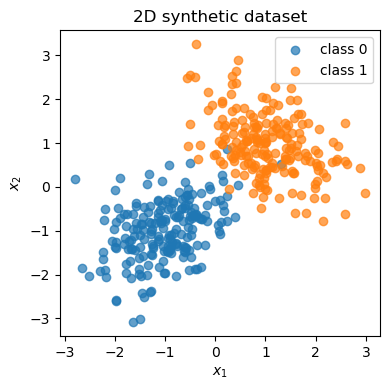

Saved figure: figs/adaptive_data_scatter.png


In [2]:
# Generate a simple 2D binary classification dataset

def generate_data(n_per_class=200):
    # Class 0: centered near (-1, -1)
    mean0 = np.array([-1.0, -1.0])
    cov0 = np.array([[0.5, 0.2],
                     [0.2, 0.5]])
    x0 = np.random.multivariate_normal(mean0, cov0, size=n_per_class)
    y0 = np.zeros(n_per_class, dtype=int)

    # Class 1: centered near (1, 1)
    mean1 = np.array([1.0, 1.0])
    cov1 = np.array([[0.5, -0.2],
                     [-0.2, 0.5]])
    x1 = np.random.multivariate_normal(mean1, cov1, size=n_per_class)
    y1 = np.ones(n_per_class, dtype=int)

    X = np.vstack([x0, x1])
    y = np.concatenate([y0, y1])
    return X, y

X, y = generate_data(n_per_class=200)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)

# Quick scatter plot of the data
plt.figure(figsize=(4, 4))
plt.scatter(X[y==0, 0], X[y==0, 1], alpha=0.7, label="class 0")
plt.scatter(X[y==1, 0], X[y==1, 1], alpha=0.7, label="class 1")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.title("2D synthetic dataset")
plt.tight_layout()
plt.savefig("figs/adaptive_data_scatter.png", dpi=200)
plt.show()

print("Saved figure: figs/adaptive_data_scatter.png")

## 2. Logistic Regression Model and Loss

We implement a simple logistic regression model with parameters
\( \theta = (w, b) \), where \(w \in \mathbb{R}^2\) and \(b \in \mathbb{R}\).

In [3]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def predict_proba(X, w, b):
    return sigmoid(X @ w + b)

def binary_cross_entropy(y_true, y_pred, eps=1e-8):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def compute_gradients(X, y, w, b):
    # Compute gradients of the binary cross-entropy loss with respect to w and b.
    y_pred = predict_proba(X, w, b)
    error = y_pred - y
    grad_w = X.T @ error / X.shape[0]
    grad_b = np.mean(error)
    return grad_w, grad_b

## 3. Training with AdaGrad, RMSProp, and Adam

We implement a generic training loop that can switch between optimizers by name.


In [4]:
def train_logreg(
    X, y, 
    optimizer="adagrad",
    num_epochs=200,
    lr=0.1,
    batch_size=64,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
):
    """
    Train logistic regression with a chosen optimizer on data (X, y).

    Parameters
    ----------
    optimizer : str
        One of {"adagrad", "rmsprop", "adam"}.
    num_epochs : int
        Number of passes over the dataset.
    lr : float
        Base learning rate.
    batch_size : int
        Mini-batch size for stochastic optimization.
    beta1, beta2 : float
        Exponential decay rates for moment estimates (used by RMSProp/Adam).
    eps : float
        Numerical stability constant.

    Returns
    -------
    history : dict
        Contains parameters, losses, and other logging information.
    """
    n_samples, n_features = X.shape
    # Initialize parameters
    w = np.zeros(n_features)
    b = 0.0

    # For shuffling
    indices = np.arange(n_samples)

    # Accumulators for optimizers
    G_w = np.zeros_like(w)  # for AdaGrad/RMSProp/Adam second moment
    G_b = 0.0
    m_w = np.zeros_like(w)  # first moment (Adam)
    m_b = 0.0

    t = 0  # time step counter for bias correction in Adam

    losses = []

    for epoch in range(num_epochs):
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            grad_w, grad_b = compute_gradients(X_batch, y_batch, w, b)
            t += 1

            if optimizer == "adagrad":
                # Accumulate squared gradients
                G_w += grad_w ** 2
                G_b += grad_b ** 2
                # Parameter-wise learning rate
                w -= lr * grad_w / (np.sqrt(G_w) + eps)
                b -= lr * grad_b / (np.sqrt(G_b) + eps)

            elif optimizer == "rmsprop":
                # Exponential moving average of squared gradients
                G_w = beta2 * G_w + (1 - beta2) * grad_w**2
                G_b = beta2 * G_b + (1 - beta2) * grad_b**2
                w -= lr * grad_w / (np.sqrt(G_w) + eps)
                b -= lr * grad_b / (np.sqrt(G_b) + eps)

            elif optimizer == "adam":
                # First moment
                m_w = beta1 * m_w + (1 - beta1) * grad_w
                m_b = beta1 * m_b + (1 - beta1) * grad_b
                # Second moment
                G_w = beta2 * G_w + (1 - beta2) * grad_w**2
                G_b = beta2 * G_b + (1 - beta2) * grad_b**2
                # Bias-corrected moments
                m_w_hat = m_w / (1 - beta1**t)
                m_b_hat = m_b / (1 - beta1**t)
                G_w_hat = G_w / (1 - beta2**t)
                G_b_hat = G_b / (1 - beta2**t)

                w -= lr * m_w_hat / (np.sqrt(G_w_hat) + eps)
                b -= lr * m_b_hat / (np.sqrt(G_b_hat) + eps)

            else:
                raise ValueError(f"Unknown optimizer: {optimizer}")

        # Compute full-batch loss at end of epoch
        y_pred_full = predict_proba(X, w, b)
        loss = binary_cross_entropy(y, y_pred_full)
        losses.append(loss)

    history = {
        "w": w,
        "b": b,
        "losses": np.array(losses),
        "optimizer": optimizer,
        "lr": lr,
        "batch_size": batch_size,
    }
    return history

## 4. Running the Three Optimizers

We now train logistic regression using AdaGrad, RMSProp, and Adam on the same dataset,
with the same number of epochs and base learning rate. This allows a fair comparison
of loss convergence.


In [5]:
num_epochs = 200
batch_size = 64
lr = 0.05

hist_adagrad = train_logreg(X, y, optimizer="adagrad",
                            num_epochs=num_epochs, lr=lr, batch_size=batch_size)
hist_rmsprop = train_logreg(X, y, optimizer="rmsprop",
                            num_epochs=num_epochs, lr=lr, batch_size=batch_size)
hist_adam    = train_logreg(X, y, optimizer="adam",
                            num_epochs=num_epochs, lr=lr, batch_size=batch_size)

print("Final losses:")
print("  AdaGrad:", hist_adagrad["losses"][-1])
print("  RMSProp:", hist_rmsprop["losses"][-1])
print("  Adam   :", hist_adam["losses"][-1])

Final losses:
  AdaGrad: 0.08699496157700196
  RMSProp: 0.050422727468607154
  Adam   : 0.0495769159061394


## 5. Loss Curves

We compare the evolution of the training loss as a function of epoch
for the three optimizers.


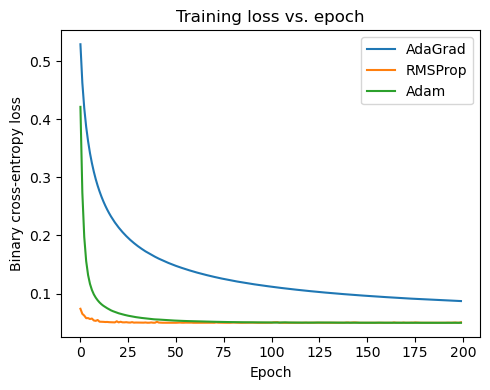

Saved figure: figs/adaptive_loss_curves.png


In [6]:
plt.figure(figsize=(5, 4))
plt.plot(hist_adagrad["losses"], label="AdaGrad")
plt.plot(hist_rmsprop["losses"], label="RMSProp")
plt.plot(hist_adam["losses"], label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.title("Training loss vs. epoch")
plt.legend()
plt.tight_layout()
plt.savefig("figs/adaptive_loss_curves.png", dpi=200)
plt.show()

print("Saved figure: figs/adaptive_loss_curves.png")

## 6. Decision Boundary Visualization

In [7]:
def plot_decision_boundary(X, y, w, b, title, filename):
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = predict_proba(grid, w, b).reshape(xx.shape)

    plt.figure(figsize=(4.5, 4))
    # Contour for p = 0.5
    plt.contour(xx, yy, probs, levels=[0.5], linestyles="solid")
    # Filled background
    plt.contourf(xx, yy, probs, levels=20, alpha=0.4)
    # Training data
    plt.scatter(X[y==0, 0], X[y==0, 1], alpha=0.8, label="class 0")
    plt.scatter(X[y==1, 0], X[y==1, 1], alpha=0.8, label="class 1")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(title)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.show()
    print(f"Saved figure: {filename}")

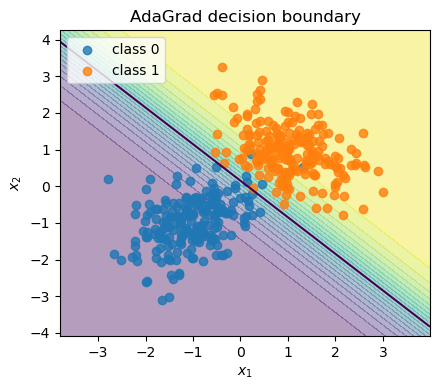

Saved figure: figs/adagrad_boundary.png


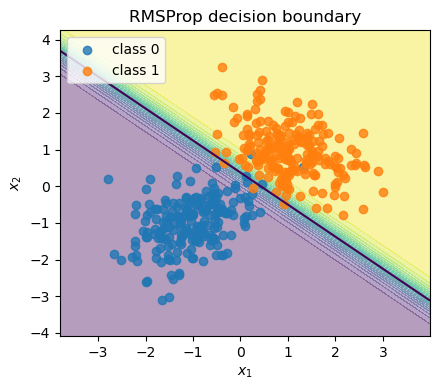

Saved figure: figs/rmsprop_boundary.png


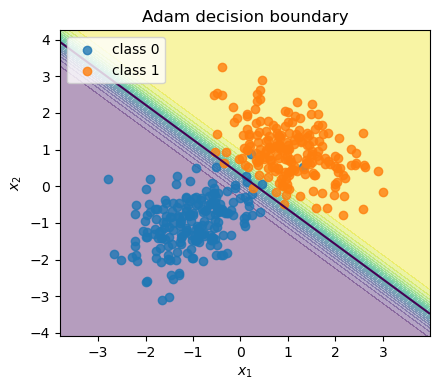

Saved figure: figs/adam_boundary.png


In [8]:
plot_decision_boundary(
    X, y,
    hist_adagrad["w"], hist_adagrad["b"],
    title="AdaGrad decision boundary",
    filename="figs/adagrad_boundary.png"
)

plot_decision_boundary(
    X, y,
    hist_rmsprop["w"], hist_rmsprop["b"],
    title="RMSProp decision boundary",
    filename="figs/rmsprop_boundary.png"
)

plot_decision_boundary(
    X, y,
    hist_adam["w"], hist_adam["b"],
    title="Adam decision boundary",
    filename="figs/adam_boundary.png"
)

## 7. Exercise: Exploring Adaptive Methods

This notebook is designed to support the exercise *Comparative Analysis of Adaptive Gradient Methods in Logistic Regression*.

Suggested directions to explore:

1. **Hyperparameter Sensitivity**
   - Vary the batch size among \(\{8, 32, 128\}\).
   - Vary the learning rate among \(\{0.01, 0.001, 0.0001\}\).
   - Observe how the loss curves and final boundaries change for each optimizer.

2. **Decision Boundary Geometry**
   - For each optimizer and each hyperparameter choice, re-plot the decision boundary.
   - Compare the smoothness and shape of the classification regions.

3. **Robustness Across Runs**
   - Re-run the training with different random seeds.
   - Study how stable each optimizer is with respect to initialization and data shuffling.

You can add new code cells below this one to carry out the experiments.
